# Terzaghi 1D Consolidation: Analytical vs FEM (FEniCSx)

This notebook benchmarks the single layer FEniCSx finite element solution of Terzaghi’s 1D diffusion consolidation equation (for pore pressure) against the Fourier-series analytical reference (found in Craigs Soil Mechanics). It aims to then quantifies error over time and preform mesh and time-step convergence studdies.

### 1.0 Problem setup
- Single soil layer with thickness \(H\), 1D vertical drainage behaviour.
- Same material parameters used in both models, else stated otherwise.
- Single drainage condition: drained boundary at the top and no-flow at the base.
- The initial condition is taken the be a uniform excess pore pressure from an instantaneous applied load. 

### 1.1 Analytical reference solution
- Closed form solution evaluated using a truncated Fourier series (with number of terms set in code).
- Used as the baseline to assess the numerical FEM accuracy.

### 1.2 FEM solution (FEniCSx)
- Weak form of the Terzaghi diffusion equation solved on a 1D mesh.
- Time integration via an Euler implicit scheme (Backward Euler).

### 1.3 Error evaluation
Errors are computed between FEM and analytical solutions over time:
- RMSE over depth at each time step.
- Normalised \(L^2\) error over soil thickness at each time step.

## 2 Convergence studies
Two studies are includes:
- Mesh convergence. Refining the spatial discretisation and track error reduction.
- Time-step convergence. vary \(\Delta t\) and track error reduction.

## 2.1 Plots and Results 
- Error vs time RMSE and normalised \(L^2\) error curves.
- Settlement vs time. Comparison beyween analytical vs FEM settlement response overlaying plot.
- Absolute error heatmap,|U_fem - U_analytical| across depth and time.
- Time-step convergence plots:*RMSE vs \(\Delta t\) on linear and log scales.

## 2.2 Notes
- Early time errors are typically larger due to sharp near-boundary gradients coarse meshes or large will exaggerate this.
- Analytical accuracy depends on the number of Fourier terms. FEM accuracy depends on spatial and temporal resolution.


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



# set up to allow juypter notebook to use local modulse from src 
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../scripts'))
sys.path.insert(0, module_path)

from terazaghi_1d.fea_fenicsx import Get_Terazaghi1D_FEA 
from terazaghi_1d.analytical import Get_Terazaghi1d_Analytical


# parameters 
H = 5
num = 50
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 1000
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

time_factor = (Cv * dt) / H**2

# n terms for analitical solution 
N_terms = 200

total_settlement = Mv*P*H

print("\nModel parameters used for analytical and FEM solutions:")
print("--------------------------------------------------------")
print(f"Layer thickness,             = {H:.2f} m")
print(f"Applied surface pressure,    = {P:.2f} kPa")
print(f"Simulation duration,         = {Tx/(60*60*24):.2f} days")
print(f"Number of time steps         = {time_step}")
print(f"Time step size               = {(dt/(60*60*24)):.2f} days")
print(f"Coefficient of consolidation = {Cv:.2e} m^2/s")
print(f"Coefficient of volume comp.  = {Mv:.2e} m^2/kN\n")
print(f"Number of elements (FEM)     = {num}")
print(f"Number of nodes (FEM)        = {nodes}\n")
print(f"Analytical series terms      = {N_terms}\n")
print(f"Dimensionless time factor    = {time_factor:.4f}")
print(f"Total Settlement             = {total_settlement:.4f} m")



Model parameters used for analytical and FEM solutions:
--------------------------------------------------------
Layer thickness,             = 5.00 m
Applied surface pressure,    = 100.00 kPa
Simulation duration,         = 365.00 days
Number of time steps         = 1000
Time step size               = 0.36 days
Coefficient of consolidation = 2.00e-07 m^2/s
Coefficient of volume comp.  = 5.00e-04 m^2/kN

Number of elements (FEM)     = 50
Number of nodes (FEM)        = 51

Analytical series terms      = 200

Dimensionless time factor    = 0.0003
Total Settlement             = 0.2500 m


# FEniCSx Solver
Single Layered FEnicsx Solver, showing outputted Local Degree of Consolidation Solution.

In [2]:
# plotting fenicsx data. to note purposely choicen different t or time_step+1 as fenicsx gives t+1 results due to uh ands 
fem_cdata = Get_Terazaghi1D_FEA(H, num, P, Tx, time_step, Cv, 0, True) # 0 as we are using uniform force 
Z = -np.linspace(0, H, num = nodes)
T = np.linspace(0,(Tx/(60*60*24)), num= time_step)
fem_cdata = pd.DataFrame(fem_cdata, columns = Z, index = T)

fem_cdata

/workspaces/Geotechnical-Consolidation-FEM/scripts/terazaghi_1d/fea_fenicsx.py:126: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


,-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-4.1,-4.2,-4.3,-4.4,-4.5,-4.6,-4.7,-4.8,-4.9,-5.0
0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.365365,1.0,0.348798,0.089544,0.022988,0.005901,0.001515,0.000389,0.000100,0.000026,0.000007,...,-4.440892e-16,-4.440892e-16,-2.220446e-16,-2.220446e-16,1.110223e-16,0.000000e+00,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16
0.730731,1.0,0.503981,0.201338,0.070160,0.022754,0.007059,0.002125,0.000626,0.000181,0.000052,...,-6.661338e-16,-6.661338e-16,-6.661338e-16,-4.440892e-16,-2.220446e-16,-4.440892e-16,-2.220446e-16,-2.220446e-16,-6.661338e-16,-6.661338e-16
1.096096,1.0,0.588915,0.291248,0.125570,0.049089,0.017907,0.006210,0.002073,0.000672,0.000212,...,-8.881784e-16,-8.881784e-16,-8.881784e-16,-6.661338e-16,-2.220446e-16,-4.440892e-16,-4.440892e-16,-6.661338e-16,-6.661338e-16,-6.661338e-16
1.461461,1.0,0.642644,0.360235,0.178946,0.080528,0.033520,0.013124,0.004894,0.001755,0.000609,...,-1.110223e-15,-1.332268e-15,-8.881784e-16,-8.881784e-16,-2.220446e-16,-4.440892e-16,-4.440892e-16,-6.661338e-16,-8.881784e-16,-1.110223e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363.538539,1.0,0.978332,0.956687,0.935087,0.913555,0.892112,0.870782,0.849586,0.828547,0.807685,...,3.432970e-01,3.377284e-01,3.328041e-01,3.285282e-01,3.249041e-01,3.219349e-01,3.196230e-01,3.179703e-01,3.169782e-01,3.166474e-01
363.903904,1.0,0.978346,0.956716,0.935130,0.913611,0.892183,0.870867,0.849685,0.828659,0.807811,...,3.437006e-01,3.381350e-01,3.332133e-01,3.289396e-01,3.253174e-01,3.223498e-01,3.200391e-01,3.183872e-01,3.173956e-01,3.170649e-01
364.269269,1.0,0.978361,0.956744,0.935172,0.913668,0.892254,0.870952,0.849783,0.828771,0.807937,...,3.441041e-01,3.385414e-01,3.336223e-01,3.293508e-01,3.257305e-01,3.227644e-01,3.204549e-01,3.188039e-01,3.178127e-01,3.174823e-01
364.634635,1.0,0.978375,0.956772,0.935215,0.913725,0.892324,0.871036,0.849882,0.828883,0.808062,...,3.445073e-01,3.389475e-01,3.340310e-01,3.297617e-01,3.261433e-01,3.231788e-01,3.208705e-01,3.192203e-01,3.182297e-01,3.178994e-01


# Analytical Solver
Showing outputted Local Degree of Consolidation Solution.

In [3]:
# analytical solution plotitng 
analytical_cdata, a_Z, = Get_Terazaghi1d_Analytical(H, Tx, time_step, num, Cv, N_terms)
a_T = np.linspace(0, Tx/(60*60*24), time_step, dtype=float)
analytical_cdata = pd.DataFrame(analytical_cdata, columns= -a_Z, index= a_T)

analytical_cdata

,-0.0,-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,...,-4.1,-4.2,-4.3,-4.4,-4.5,-4.6,-4.7,-4.8,-4.9,-5.0
0.000000,1.0,0.050069,0.025268,0.016888,0.012689,0.010169,8.490676e-03,7.294024e-03,6.398483e-03,5.703780e-03,...,1.657345e-03,1.643161e-03,1.630814e-03,1.620238e-03,1.611378e-03,1.604189e-03,1.598634e-03,1.594686e-03,1.592325e-03,1.591539e-03
0.365365,1.0,0.373511,0.075103,0.007591,0.000371,0.000009,9.320261e-08,4.681703e-10,1.084910e-12,1.221245e-15,...,-2.220446e-16,-6.661338e-16,0.000000e+00,-4.440892e-16,6.661338e-16,-1.332268e-15,-4.440892e-16,-1.332268e-15,5.551115e-16,-2.220446e-16
0.730731,1.0,0.529175,0.208199,0.059053,0.011834,0.001653,1.596245e-04,1.058503e-05,4.800236e-07,1.484058e-08,...,-4.440892e-16,-2.220446e-16,7.771561e-16,1.110223e-16,-2.220446e-16,-1.110223e-15,-8.881784e-16,-1.776357e-15,-8.881784e-16,1.110223e-16
1.096096,1.0,0.607396,0.304144,0.123224,0.039862,0.010200,2.050888e-03,3.224579e-04,3.950598e-05,3.761489e-06,...,1.110223e-16,5.551115e-16,6.661338e-16,-2.220446e-16,2.220446e-16,-1.110223e-15,-1.110223e-15,-1.110223e-15,-2.220446e-16,-2.220446e-16
1.461461,1.0,0.656350,0.373511,0.181917,0.075103,0.026095,7.590760e-03,1.841264e-03,3.713246e-04,6.211569e-05,...,-2.220446e-16,1.110223e-16,0.000000e+00,-8.881784e-16,5.551115e-16,-1.332268e-15,-2.220446e-16,-1.332268e-15,1.110223e-16,-2.220446e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363.538539,1.0,0.978335,0.956693,0.935096,0.913566,0.892126,8.707990e-01,8.496058e-01,8.285688e-01,8.077096e-01,...,3.433249e-01,3.377555e-01,3.328305e-01,3.285539e-01,3.249292e-01,3.219596e-01,3.196473e-01,3.179943e-01,3.170020e-01,3.166711e-01
363.903904,1.0,0.978349,0.956721,0.935138,0.913623,0.892197,8.708837e-01,8.497044e-01,8.286810e-01,8.078354e-01,...,3.437287e-01,3.381623e-01,3.332398e-01,3.289654e-01,3.253427e-01,3.223745e-01,3.200634e-01,3.184113e-01,3.174195e-01,3.170888e-01
364.269269,1.0,0.978364,0.956750,0.935181,0.913680,0.892268,8.709684e-01,8.498028e-01,8.287932e-01,8.079610e-01,...,3.441323e-01,3.385688e-01,3.336489e-01,3.293767e-01,3.257559e-01,3.227893e-01,3.204794e-01,3.188281e-01,3.178368e-01,3.175063e-01
364.634635,1.0,0.978378,0.956778,0.935224,0.913736,0.892339,8.710530e-01,8.499012e-01,8.289052e-01,8.080865e-01,...,3.445356e-01,3.389750e-01,3.340578e-01,3.297878e-01,3.261689e-01,3.232038e-01,3.208951e-01,3.192447e-01,3.182539e-01,3.179236e-01


# Computing for Error 

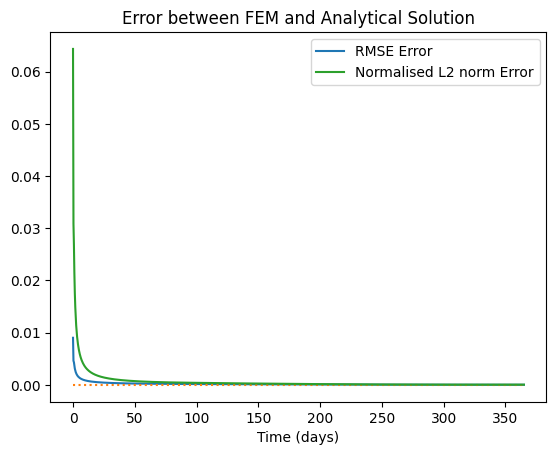

In [4]:
# assumes that the t and z for both data is identical in which it is 
error = fem_cdata - analytical_cdata
#RMSE error per time step 
RMSE = np.sqrt((error**2).mean(axis = 1))
# Normalised L2 norm error 
num = (error**2).sum(axis = 1)
den = (analytical_cdata**2).sum(axis = 1)
E_L2 = np.sqrt(num / (den+ 1e-12))
time = np.linspace(0, (Tx/(60*60*24)), time_step)


# plotting err
plt.figure()
plt.plot(time, RMSE, label = "RMSE Error")
plt.plot([0,np.max(time)],[0,0], linestyle ="dotted")  # Please change for capture of map
plt.plot(time, E_L2, label = "Normalised L2 norm Error")
plt.xlabel("Time (days)")
plt.legend()
plt.title("Error between FEM and Analytical Solution")
plt.show()


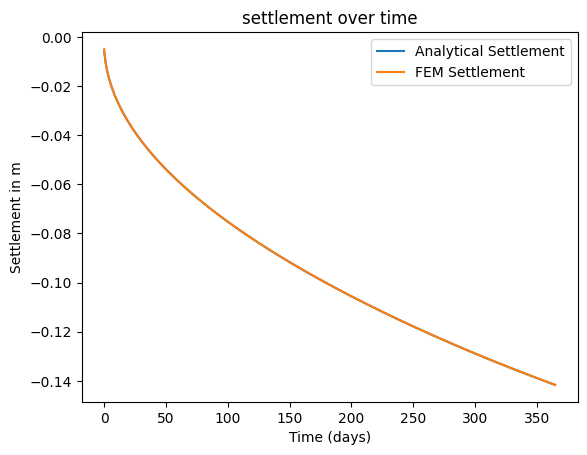

total settlement: 0.25 m
total consolidation settlement reach. 
analytical: 0.1417m 
FEM: 0.1416m 
actual total settlememt: 0.25 


In [5]:

# drawing settlement with time plotting 
analytical_settlement= analytical_cdata.mean(axis=1)*total_settlement
fem_settlement = fem_cdata.mean(axis=1)*total_settlement

plt.figure()
plt.plot(time, -analytical_settlement, label="Analytical Settlement")
plt.plot(time, -fem_settlement, label="FEM Settlement")
plt.xlabel("Time (days)")
plt.ylabel("Settlement in m")
plt.legend()
plt.title("settlement over time")
plt.show()
print(f"total settlement: {total_settlement} m")

print(f"total consolidation settlement reach. \nanalytical: {np.max(analytical_settlement):.4f}m \nFEM: {np.max(fem_settlement):.4}m \nactual total settlememt: {total_settlement:.4} ")

# Heat Map Representation through out time 
note: these use local degree of consolidation and not settlement

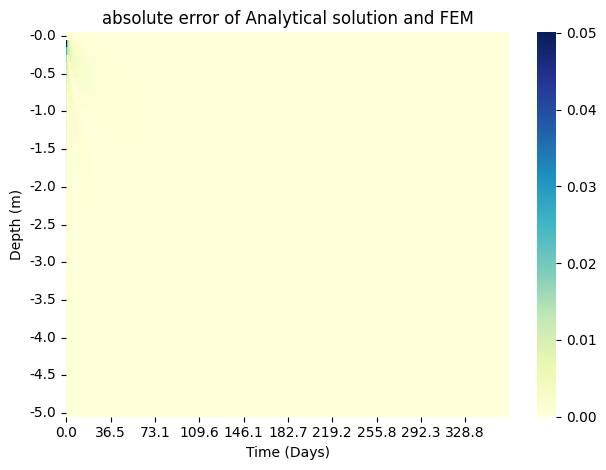

In [6]:
time = time
depth = Z

kx = max(1, len(time)//10)    # ~8 labels across, auto
ky = max(1, len(depth)//10)  # ~10 labels down, auto 


ax = sns.heatmap(abs(error).T, annot=False, cmap="YlGnBu", 
                 xticklabels=time, yticklabels=depth)

ax.set_xticks(np.arange(0, len(time), kx) + 0.5)
ax.set_xticklabels([f"{time[i]:.1f}" for i in range(0, len(time), kx)],
                   rotation=0)

ax.set_yticks(np.arange(0, len(depth), ky) + 0.5)
ax.set_yticklabels([f"{depth[i]:.1f}" for i in range(0, len(depth), ky)],
                   rotation=0)

ax.set_xlabel("Time (Days)")
ax.set_ylabel("Depth (m)")
ax.set_title("absolute error of Analytical solution and FEM")
plt.tight_layout()
plt.show()




# Mesh refinement and time interval refinemenet convergency testing

Using RSME and the normalised L^2 to assess the convergency of these values in comparison to the analytical solutions

Since the finite element methods is sensitive to parameters inputted, I have raised the n terms in the analytical solutions to more accuractly evalute the error between more finer meshes (from 200 to 400). Additionally, since finer mesh become more sensitive to time steps alongside, when increasing the mesh sizes a large assocated time step has also been increase, these have been increased otherwise more signficant error arises. However there is still a large error seen within the sequencing foriour solutions.


In [7]:
mesh_size = [10,25,50,100,200]
time_step = [40,250,1000,4000,16000]



N_terms = 400

mesh_size = np.array(mesh_size, dtype = int)
time_step = np.array(time_step, dtype = int)
RMSE_Vals = []

for nx, timestep in zip(mesh_size,time_step):
    fem_cdata = Get_Terazaghi1D_FEA(H, nx, P, Tx, timestep, Cv, 0, True) 
    analytical_cdata, a_Z, = Get_Terazaghi1d_Analytical(H, Tx, timestep, nx, Cv, N_terms)

    error = fem_cdata - analytical_cdata
    RMSE = np.sqrt(np.mean(error**2))  
    RMSE_Vals = np.append(RMSE_Vals, RMSE)     
    

    print(f"for {nx} amount of cells the assocaited RMSE is {RMSE}")



/workspaces/Geotechnical-Consolidation-FEM/scripts/terazaghi_1d/fea_fenicsx.py:126: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


for 10 amount of cells the assocaited RMSE is 0.0038637630286619063
for 25 amount of cells the assocaited RMSE is 0.001080655342759314
for 50 amount of cells the assocaited RMSE is 0.00041348896028401197
for 100 amount of cells the assocaited RMSE is 0.00017242951728010844
for 200 amount of cells the assocaited RMSE is 8.627396416062831e-05


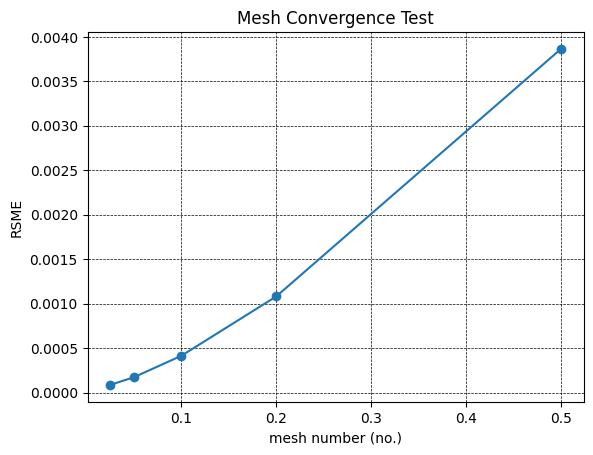

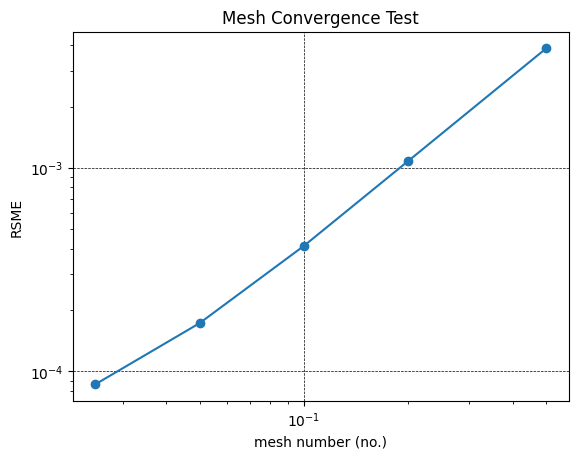

In [11]:

plt.plot(H/mesh_size, RMSE_Vals, marker = "o")
plt.grid(color = "black", linestyle = "--", linewidth = "0.5")
plt.xlabel("mesh number (no.)")
plt.ylabel("RSME")
plt.title("Mesh Convergence Test")
plt.show()


plt.loglog(H/mesh_size, RMSE_Vals, marker = "o")
plt.grid(color = "black", linestyle = "--", linewidth = "0.5")
plt.xlabel("mesh number (no.)")
plt.ylabel("RSME")
plt.title("Mesh Convergence Test")
plt.show()




In [12]:
# parameters 
H = 5
num = 50
nodes = num + 1
P = 100 # stress applied 
Tx = 60*60*24*365 # seconds to a year Please keeps this within days 
time_step = 1000
dt = Tx / time_step
Cv = 2e-7 # m^2/s (coefficient of consolidation)
Mv = 5e-4 # 1/kPa  (or m^2/kN)

# n terms for analitical solution 
N_terms = 400


time_step = [100,200,400,800,1600]

time_step = np.array(time_step)
RMSE_i = []

for i in time_step:
    fem_cdata = Get_Terazaghi1D_FEA(H, num, P, Tx, i, Cv, 0, True) 
    analytical_cdata, a_Z, = Get_Terazaghi1d_Analytical(H, Tx, i, num, Cv, N_terms)

    error = fem_cdata - analytical_cdata
    RMSE = np.sqrt(np.mean(error**2))  
    RMSE_i = np.append(RMSE_i, RMSE)     
    

    print(f"for {i} amount of cells the assocaited RMSE is {RMSE}")


/workspaces/Geotechnical-Consolidation-FEM/scripts/terazaghi_1d/fea_fenicsx.py:126: RuntimeWarning: invalid value encountered in divide
  local_dcons = 1 - u_hist / u0[None,:]


for 100 amount of cells the assocaited RMSE is 0.00444690717704185
for 200 amount of cells the assocaited RMSE is 0.002507636300604272
for 400 amount of cells the assocaited RMSE is 0.0013060985247999566
for 800 amount of cells the assocaited RMSE is 0.0005728901972681896
for 1600 amount of cells the assocaited RMSE is 0.00022426544609410978


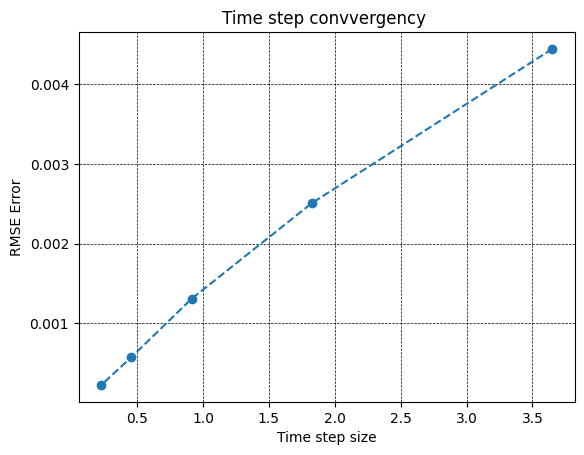

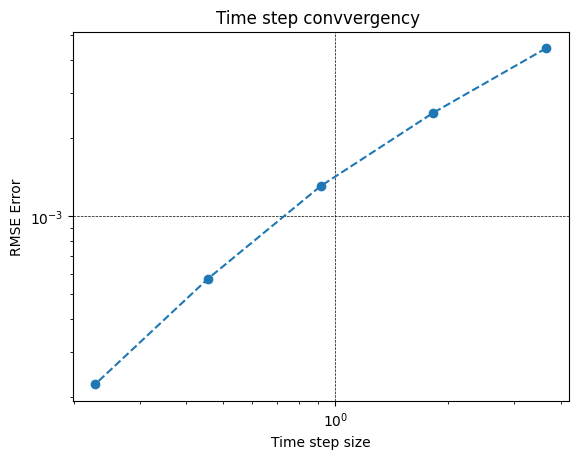

In [13]:

fig , ax = plt.subplots()

ax.set_xlabel("Time step size")

ax.plot(((Tx/(60*60*24))/time_step), RMSE_i, 'o--')
ax.grid(color = "black", linestyle = "--", linewidth = "0.5")


ax.set_ylabel("RMSE Error")
ax.set_title("Time step convvergency ")
plt.show()

logfig, logax = plt.subplots()

logax.set_xlabel("Time step size")

logax.loglog(((Tx/(60*60*24))/time_step), RMSE_i, 'o--')
logax.grid(color = "black", linestyle = "--", linewidth = "0.5")


logax.set_ylabel("RMSE Error")
logax.set_title("Time step convvergency ")
plt.show()



# Monte Carlo Simulations 
normal distribution for Mv
log normal distribution for Permeability 